# Analyse socio-économique des communes

Objectif : identifier et prioriser les communes nécessitant
des investissements publics à partir d’indicateurs démographiques
et de revenus.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Chargement des données nettoyées
CLEAN_PATH = "/content/drive/MyDrive/Projet Data/projet_1_diagnostic_territorial/data/clean/"

pop = pd.read_csv(CLEAN_PATH + "population_clean.csv")
rev = pd.read_csv(CLEAN_PATH + "revenus_clean.csv")

pop.head(), rev.head()

(  dep codgeo                 libgeo  population
 0  85  85062            Châteauneuf      1134.0
 1  58  58300                   Urzy      1742.0
 2  70  70137  Chassey-lès-Montbozon       225.0
 3  51  51649      Vitry-le-François     11454.0
 4  78  78638         Vaux-sur-Seine      5083.0,
   codgeo                   libgeo  revenu_median
 0  01001  L'Abergement-Clémenciat        25820.0
 1  01002    L'Abergement-de-Varey        24480.0
 2  01004        Ambérieu-en-Bugey        21660.0
 3  01005      Ambérieux-en-Dombes        24610.0
 4  01006                  Ambléon        24210.0)

In [ ]:
#Verifions si la colonne "codgeo" des deux dataframe sont de même types avant de procéder à la jointure
pop["codgeo"].dtype, rev["codgeo"].dtype

(dtype('O'), dtype('O'))

In [ ]:
#Jointures des dataframes de la population et des revenues à gauche avec pour clé le "codgeo" et en gardant toutes le commune et les valeurs manquantes
df = pop.merge(
    rev[["codgeo", "revenu_median"]],
    on="codgeo",
    how="left"
)

df.head()

,dep,codgeo,libgeo,population,revenu_median
0,85,85062,Châteauneuf,1134.0,22110.0
1,58,58300,Urzy,1742.0,24410.0
2,70,70137,Chassey-lès-Montbozon,225.0,22710.0
3,51,51649,Vitry-le-François,11454.0,17890.0
4,78,78638,Vaux-sur-Seine,5083.0,29160.0


In [ ]:
df.describe()

,population,revenu_median,revenu_par_habitant,pression_socioeco
count,34969.000000,31262.000000,31253.000000,31253.000000
mean,1927.597701,23253.697780,59.957292,0.238630
std,8737.679677,3167.264763,53.779566,1.061509
min,0.000000,12260.000000,0.043922,0.000000
25%,197.000000,21270.000000,18.039724,0.029785
50%,458.000000,22810.000000,42.814259,0.061698
75%,1167.000000,24720.000000,87.928287,0.147389
max,504078.000000,55340.000000,355.818182,59.992772


La jointure est réalisée en left join afin de conserver
l’ensemble des communes, même lorsque les données de revenu
ne sont pas disponibles (secret statistique).


In [ ]:
# Vérifions la taille de la dataframe
df.shape

(34995, 5)

Toutes les communnes ont été conservées ainsi que les valeurs manquantes telles la réalité terrain

In [ ]:
#Trouuvons les nombres de communes sans revenue enregistrées
df["revenu_median"].isna().sum()

np.int64(3733)

Il y près de 3800 communes dont les revenues ne sont pas enregistrées ce qui présente 10% de la taille du dataframe

In [ ]:
# Création d’indicateurs métier simples
df["revenu_par_habitant"] = df["revenu_median"] / df["population"] #Création de la colonne revenue par habitant
df["categorie_revenu"] = pd.qcut(
    df["revenu_median"],
    q=4,
    labels=["Très faible", "Faible", "Moyen", "Élevé"]
)                                                                  #Catégorisation par revenu facile à comprendre en 4 quartilles
df[["dep","libgeo", "population", "revenu_median", "categorie_revenu"]].head(10) #Vérification de la dataframe

,dep,libgeo,population,revenu_median,categorie_revenu
0,85,Châteauneuf,1134.0,22110.0,Faible
1,58,Urzy,1742.0,24410.0,Moyen
2,70,Chassey-lès-Montbozon,225.0,22710.0,Faible
3,51,Vitry-le-François,11454.0,17890.0,Très faible
4,78,Vaux-sur-Seine,5083.0,29160.0,Élevé
5,63,Chappes,1617.0,25490.0,Élevé
6,57,Freistroff,1020.0,24070.0,Moyen
7,66,Brouilla,1581.0,22360.0,Faible
8,27,Mouflaines,164.0,22300.0,Faible
9,42,Montverdun,1322.0,22750.0,Faible


## Indicateur de pression socio-économique

### Formule

L’indicateur de pression socio-économique est défini comme :

$$
\text{Pression socio-économique} = \left( \frac{\text{Population de la commune}}{\max(\text{Population})} \right) \times \left( 1 - \frac{\text{Revenu médian de la commune}}{\max(\text{Revenu médian})} \right)
$$





In [ ]:
#Création de la colonne de la pression socio-économique
df["pression_socioeco"] = (
    (df["population"] / df["population"].max()) *
    (1 - df["revenu_median"] / df["revenu_median"].max()) * 100
)
df.head()

,dep,codgeo,libgeo,population,revenu_median,revenu_par_habitant,categorie_revenu,pression_socioeco
0,85,85062,Châteauneuf,1134.0,22110.0,19.497354,Faible,0.135085
1,58,58300,Urzy,1742.0,24410.0,14.012629,Moyen,0.193148
2,70,70137,Chassey-lès-Montbozon,225.0,22710.0,100.933333,Faible,0.026319
3,51,51649,Vitry-le-François,11454.0,17890.0,1.561900,Très faible,1.537702
4,78,78638,Vaux-sur-Seine,5083.0,29160.0,5.736770,Élevé,0.477038


### Interprétation des composantes

- **Population normalisée**  
  Permet de mesurer le poids démographique relatif de chaque commune.  
  Une commune très peuplée concentre davantage de besoins en services publics.

- **Revenu médian inversé et normalisé**  
  Plus le revenu médian est faible, plus la vulnérabilité socio-économique est élevée.  
  L’inversion (\(1 - x\)) permet d’attribuer une valeur élevée aux communes les plus modestes.


### Pourquoi cet indicateur ?

Cet indicateur vise à répondre à une logique de **priorisation des politiques publiques** :

- Il identifie les communes où **la pression sociale est potentiellement la plus forte**
- Il combine **ampleur du besoin (population)** et **fragilité économique (revenu)**
- Il reste **simple, transparent et interprétable**, ce qui est essentiel pour des décideurs non techniques


In [ ]:
#Ressortir une dataframe qui represente les communes avec des populations très élevées et un faible revenu
prioritaires = df[
    (df["population"] > df["population"].quantile(0.75)) &
    (df["categorie_revenu"].isin(["Très faible", "Faible"]))
].sort_values("population", ascending=False)

prioritaires.head(10)


,dep,codgeo,libgeo,population,revenu_median,revenu_par_habitant,categorie_revenu,pression_socioeco
30741,31,31555,Toulouse,504078.0,22140.0,0.043922,Faible,59.992772
18432,06,06088,Nice,348085.0,21570.0,0.061968,Faible,42.138539
13766,34,34172,Montpellier,302454.0,19670.0,0.065035,Très faible,38.674574
27689,67,67482,Strasbourg,291313.0,20260.0,0.069547,Très faible,36.633849
9940,59,59350,Lille,236710.0,20520.0,0.086688,Très faible,29.546665
16295,35,35238,Rennes,225081.0,22770.0,0.101164,Faible,26.279657
27533,83,83137,Toulon,180452.0,20960.0,0.116153,Très faible,22.239790
6198,51,51454,Reims,179380.0,20210.0,0.112666,Très faible,22.589950
15227,42,42218,Saint-Étienne,172718.0,19010.0,0.110064,Très faible,22.493969
17379,76,76351,Le Havre,166058.0,20180.0,0.121524,Très faible,20.930123


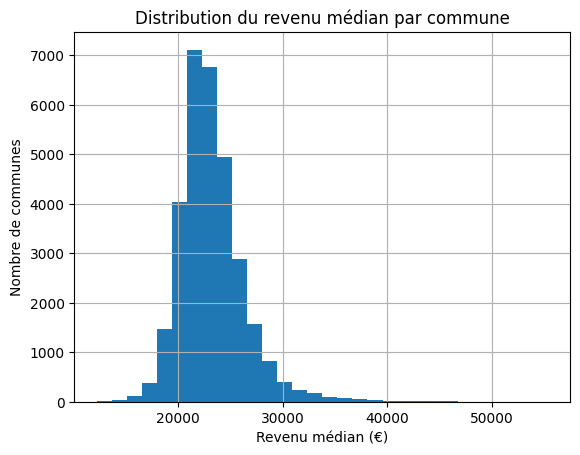

In [ ]:
#Diagramme de distribution des revenue
df["revenu_median"].hist(bins=30)
plt.title("Distribution du revenu médian par commune")
plt.xlabel("Revenu médian (€)")
plt.ylabel("Nombre de communes")
plt.show()


### Analyse de la distribution des revenus

La distribution du revenu médian par commune n’est pas normale.
Elle présente une asymétrie marquée à droite, caractérisée par une
forte concentration de communes autour de 20 000 à 25 000 € et une
queue étendue vers les revenus élevés.

Ce comportement est typique des données de revenus et justifie :
- l’utilisation de la médiane plutôt que de la moyenne
- le recours à des méthodes robustes (quantiles, catégorisation)
- une prudence dans l’interprétation des valeurs extrêmes


In [ ]:
df_dashboard = df[[ "dep",
    "codgeo",
    "libgeo",
    "population",
    "revenu_median",
    "categorie_revenu",
    "pression_socioeco"
]]

df_dashboard.to_csv(
    "/content/drive/MyDrive/Projet Data/projet_1_diagnostic_territorial/data/clean/df_analyse.csv",
    index=False
)
df_dashboard.head()

,dep,codgeo,libgeo,population,revenu_median,categorie_revenu,pression_socioeco
0,85,85062,Châteauneuf,1134.0,22110.0,Faible,0.135085
1,58,58300,Urzy,1742.0,24410.0,Moyen,0.193148
2,70,70137,Chassey-lès-Montbozon,225.0,22710.0,Faible,0.026319
3,51,51649,Vitry-le-François,11454.0,17890.0,Très faible,1.537702
4,78,78638,Vaux-sur-Seine,5083.0,29160.0,Élevé,0.477038


## Principaux enseignements
- Certaines communes cumulent forte population et faible revenu médian
- Ces territoires présentent une pression socio-économique élevée
- Les données de revenu manquantes concernent principalement de petites communes

## Recommandations
- Prioriser les investissements dans les communes à forte pression socio-économique
- Compléter l’analyse avec des données d’équipements publics
- Mettre en place un suivi via un dashboard décisionnel
